In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge, Lasso, LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
rnafold = pd.read_csv('datasets/rnacofold.csv')#[['crRNA', 'tracrRNA', 'fluo_8h']]
rnafold['sequence'] = rnafold['crRNA'] + rnafold['tracrRNA']
#rnafold = rnafold[['sequence', 'fluo_8h']]
#rnafold

In [3]:
add_col = ['MFE', 'free_energy_thermodynamic_ensemble', 'frequency_MFR_structures', 'delta_G', \
           'GC_content', 'GC_7bp', 'percent_match_no_spacer', 'percent_match_with_spacer', 'homology']

In [4]:
def getKmers(sequence, size=3):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

In [5]:
rnafold['words'] = rnafold.apply(lambda x: getKmers(x['sequence']), axis=1)

In [6]:
y = rnafold['fluo_8h']
y

0     68759.32
1     23483.95
2       814.91
3     67539.29
4     55101.14
        ...   
85    70345.84
86    20478.49
87    65102.68
88    54328.28
89    60482.51
Name: fluo_8h, Length: 90, dtype: float64

In [139]:
yc = to_categorical(pd.qcut(y, 3, labels=False))

In [140]:
texts = list(rnafold['words'])
for item in range(len(texts)):
    texts[item] = ' '.join(texts[item])

In [141]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(2, 2))
X = cv.fit_transform(texts)
X1 = pd.concat([pd.DataFrame(X.toarray()), rnafold[add_col]], axis=1)
X2 = rnafold[add_col]

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, yc, test_size=0.2)

In [145]:
rf = RandomForestClassifier()
classifier = MultiOutputClassifier(estimator=rf)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(accuracy_score(y_test, y_pred))
#sns.regplot(y_test, y_pred)
#plt.show()

0.05555555555555555


In [144]:
y_test, y_pred

(array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.]], dtype=float32),
 array([[0., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 1.],
        [1., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=float32))

In [90]:
regressors = [
    ('Linear Regressor', LinearRegression()),
    ('Ridge Regressor', Ridge()),
    ('Lasso Regressor', Lasso()),
    #('SGD Regressor', SGDRegressor()),
    ('k Nearest Neighbors', KNeighborsRegressor()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('Linear SVM', SVR(kernel='linear')),
    ('RBF Regressor', SVR(kernel='rbf')),
    ('Random Forest', RandomForestRegressor()),
    ('Gradient Boosting', RandomForestRegressor()),
    ('Neural Network (MLP)', MLPRegressor())
]
results = []
for regressor in regressors:
    print(regressor[0])
    cv_results = cross_validate(regressor[1], X, y, cv=5, scoring=('r2', 'neg_mean_squared_error'))
    mse = ([np.sqrt(i) for i in (cv_results['test_neg_mean_squared_error'] * -1)]) 
    #std = ([np.sqrt(i) for i in (cv_results['test_neg_mean_squared_error'] * -1)])
    for m in mse:
        results.append(('Sequence only', regressor[0], m))
    #for s in std:
    #    results.append(('Sequence-only', regressor[0], s))

for regressor in regressors:
    print(regressor[0])
    cv_results = cross_validate(regressor[1], X1, y, cv=5, scoring=('r2', 'neg_mean_squared_error'))
    mse = ([np.sqrt(i) for i in (cv_results['test_neg_mean_squared_error'] * -1)]) 
    #std = ([np.sqrt(i) for i in (cv_results['test_neg_mean_squared_error'] * -1)])
    for m in mse:
        results.append(('Sequence+added features', regressor[0], m))
    #for s in std:
    #    results.append(('X1', regressor[0], s))
        
for regressor in regressors:
    print(regressor[0])
    cv_results = cross_validate(regressor[1], X2, y, cv=5, scoring=('r2', 'neg_mean_squared_error'))
    mse = ([np.sqrt(i) for i in (cv_results['test_neg_mean_squared_error'] * -1)]) 
    #std = ([np.sqrt(i) for i in (cv_results['test_neg_mean_squared_error'] * -1)])
    for m in mse:
        results.append(('Added features', regressor[0], m))
    #for s in std:
    #    results.append(('X2', regressor[0], s))
    
perf = pd.DataFrame(results, columns=['Features', 'Model', 'RMSE'])
perf

Linear Regressor
Ridge Regressor
Lasso Regressor


/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20981016.751628608, tolerance: 3049886.3056941684
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17116163.765109923, tolerance: 3244804.845717479
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18999196.456494477, tolerance: 2786895.640280479
  model = cd_fast.sparse_enet_coord

k Nearest Neighbors
Decision Tree
Linear SVM
RBF Regressor
Random Forest
Gradient Boosting
Neural Network (MLP)


/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached 

Linear Regressor
Ridge Regressor
Lasso Regressor


/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28684967.180243675, tolerance: 3244804.845717479
  model = cd_fast.enet_coordinate_descent(
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24055974.350457005, tolerance: 2786895.640280479
  model = cd_fast.enet_coordinate_descent(
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32547437.513418198, tolerance: 3818603.7524996772
  model = cd_fast.enet_coordinate_descent(
/Users

k Nearest Neighbors
Decision Tree
Linear SVM
RBF Regressor
Random Forest
Gradient Boosting
Neural Network (MLP)


/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached 

Linear Regressor
Ridge Regressor
Lasso Regressor
k Nearest Neighbors
Decision Tree
Linear SVM
RBF Regressor
Random Forest
Gradient Boosting
Neural Network (MLP)


/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached 

,Features,Model,RMSE
0,Sequence only,Linear Regressor,31656.458593
1,Sequence only,Linear Regressor,26921.338470
2,Sequence only,Linear Regressor,22883.114272
3,Sequence only,Linear Regressor,21196.742505
4,Sequence only,Linear Regressor,25869.648036
...,...,...,...
145,Added features,Neural Network (MLP),46935.196868
146,Added features,Neural Network (MLP),44122.652050
147,Added features,Neural Network (MLP),40313.256910
148,Added features,Neural Network (MLP),49020.545386


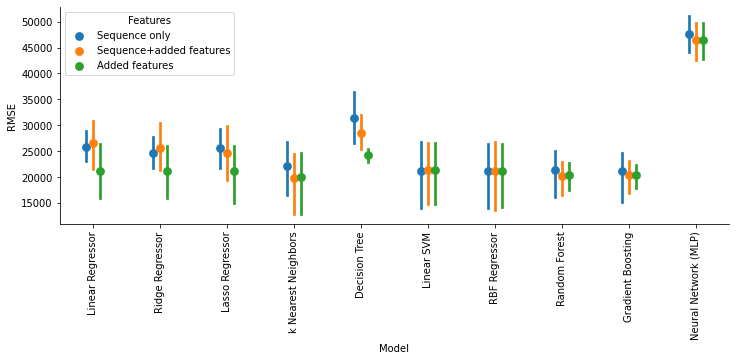

In [110]:
plt.figure(figsize=[12, 4])
sns.pointplot(data=perf, x='Model', y='RMSE', hue='Features', dodge=0.2, join=False)
plt.xticks(rotation=90)
plt.ylabel('RMSE')
sns.despine()
plt.show()

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2)
print(X_train.shape)
print(X_test.shape)

(72, 256)
(18, 256)


In [97]:
results = []
for regressor in regressors:
    regressor[1].fit(X_train, y_train)
    y_pred = regressor[1].predict(X_test)
    print(regressor[0])
    results.append((regressor[0], y_test, (y_test - y_pred)))

Linear Regressor
Ridge Regressor
Lasso Regressor
k Nearest Neighbors
Decision Tree
Linear SVM
RBF Regressor


/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12269247.521105133, tolerance: 3265140.4497967283
  model = cd_fast.sparse_enet_coordinate_descent(


Random Forest
Gradient Boosting
Neural Network (MLP)


/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


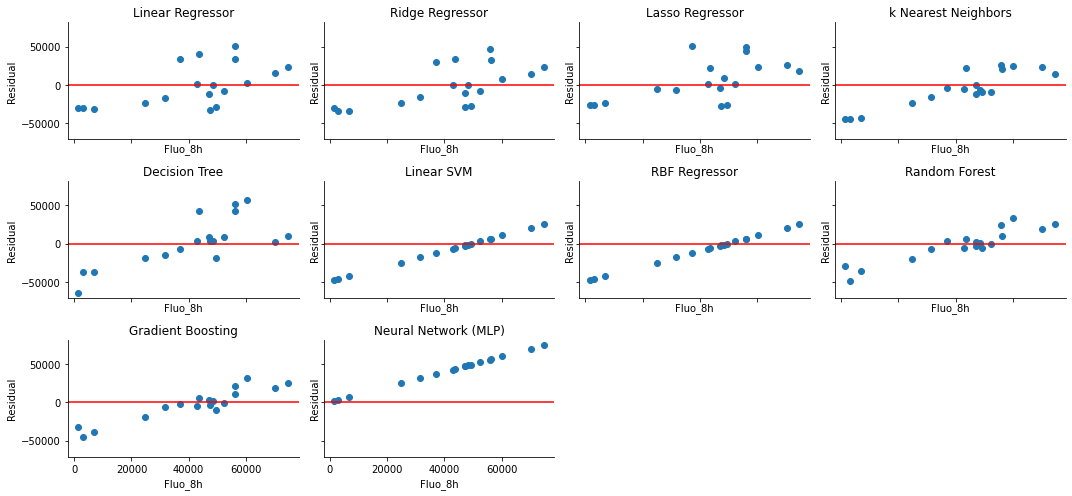

In [115]:
f, axs = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(15, 7))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < 10:
        ax.scatter(results[i][1], results[i][2])
        ax.axhline(y=0, color='r', linestyle='-')
        ax.set_title(results[i][0])
        #plt.xticks(rotation=90)
        ax.set_xlabel('Fluo_8h')
        ax.set_ylabel('Residual')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
from sklearn.model_selection import ParameterGrid
params = {
    'kmers': [2, 3, 4, 5],
    'ngram_low': [1, 2],
    'ngram_up': [3, 4] 
}

perf = []
grid = ParameterGrid(params)
for g in grid:
    
    df = rnafold[['sequence', 'fluo_8h']]
    df['words'] = df.apply(lambda x: getKmers(x['sequence'], g['kmers']), axis=1)
    
    texts = list(df['words'])
    for item in range(len(texts)):
        texts[item] = ' '.join(texts[item])
    cv = CountVectorizer(ngram_range=(g['ngram_low'], g['ngram_up']))
    X = cv.fit_transform(texts)
    y = df['fluo_8h']
    
    X_train, X_test, y_train, y_test = train_test_split(X1, 
                                                    y, 
                                                    test_size = 0.20, random_state=42)
    
    regressor = RandomForestRegressor()
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    perf.append(mean_squared_error(y_test, y_pred))
    
perf

In [ ]:
best_idx = perf.index(max(perf))
best_params = (list(grid))[best_idx]
best_params

In [ ]:
df = rnafold[['sequence', 'fluo_8h']]
df['words'] = df.apply(lambda x: getKmers(x['sequence'], 4), axis=1)

texts = list(df['words'])
for item in range(len(texts)):
    texts[item] = ' '.join(texts[item])
cv = CountVectorizer(ngram_range=(2, 4))
X = cv.fit_transform(texts)
y = df['fluo_8h']

X_train, X_test, y_train, y_test = train_test_split(X1, 
                                                y, 
                                                test_size = 0.20, random_state=42)

regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
sns.regplot(y_test, y_pred)
plt.show()

### Regressor Method

In [ ]:
rnafold = pd.read_csv('datasets/rnacofold.csv')
X = rnafold.iloc[:,5:].drop('fluo_8h', axis=1)
y = rnafold['fluo_8h']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)
mse = mean_squared_error(y_test, rf_reg.predict(X_test))
r2 = r2_score(y_test, rf_reg.predict(X_test))
mse, r2

In [ ]:
y_pred = rf_reg.predict(X_test)
plt.scatter(y_pred, y_test)
plt.show()

In [ ]:
sns.distplot(rnafold['fluo_8h'])
plt.show()

In [ ]:
sns.distplot(MinMaxScaler().fit_transform([rnafold['fluo_8h']]))
plt.show()

In [ ]:
MinMaxScaler().fit_transform(np.array(rnafold['fluo_8h']).reshape(1, -1))

In [ ]:
sns.pairplot(rnafold)
plt.show()

### Convolutional Neural Network

In [125]:
import numpy as np
import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import to_categorical

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [ ]:
yh = pd.qcut(y, 10, labels=False)
yh

In [ ]:
X2 = X.toarray()
X_train, X_test, y_train, y_test = train_test_split(X2, yh, test_size=0.2)
print(X_train.shape)

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam, Adadelta
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2, l1

In [ ]:
X_train = np.expand_dims(X_train, axis=0)
X_test = np.expand_dims(X_test, axis=0)
y_train = np.expand_dims(y_train, axis=0)
y_test = np.expand_dims(y_test, axis=0)

In [ ]:
model = Sequential()

model.add(Conv1D(filters = 32, kernel_size = 5, padding = 'same', 
                 kernel_initializer = 'he_uniform', 
                 input_shape=X_train[1:].shape, activation = 'relu',
                 kernel_regularizer=l2(0.001)))
model.add(Conv1D(filters = 32, kernel_size = 5, padding = 'same', 
                 kernel_initializer = 'he_uniform', 
                 activation = 'relu',
                 kernel_regularizer=l2(0.001)))
model.add(MaxPooling1D(pool_size = 2))

model.add(Flatten())
model.add(Dense(16, kernel_initializer= 'he_uniform', activation = 'relu',
                kernel_regularizer=l2(0.001)))
model.add(Dense(2, activation='softmax'))

epochs = 200
lrate = 0.001
decay = lrate / epochs
sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['binary_accuracy'])
model.summary()

In [ ]:
model.fit(X_train, y_train,validation_data=(X_test, y_test),
              batch_size=32, epochs=10, verbose=1)

In [ ]:
# 2. Preprocess input data
X_train = X_train.reshape(X_train.shape[0], 1, 55, 64)  # (90, 55, 64) --> (90, 1, 55, 64)
X_test = X_test.reshape(X_test.shape[0], 1, 55, 64)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# 3. Preprocess class labels; i.e. convert 1-dimensional class arrays to 3-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 2)
Y_test = np_utils.to_categorical(y_test, 2)

# 4. Define model architecture
model = Sequential()

model.add(Convolution2D(54, 3, 3, activation='relu', input_shape=(1, 55, 64)))
model.add(Convolution2D(54, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))   # since 2 classes

# 5. Compile model
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

# 6. Fit model on training data
model.fit(X_train, Y_train,validation_data=(X_test,Y_test),
              batch_size=32, nb_epoch=10, verbose=1)

# 7. Evaluate model on test data
score = model.evaluate(X_test, Y_test, verbose=1)
print("score = " + str(score))

In [ ]:
import numpy as np
import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import to_categorical

train_images = mnist.train_images()
train_labels = mnist.train_labels()
test_images = mnist.test_images()
test_labels = mnist.test_labels()

# Normalize the images.
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5

# Reshape the images.
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

num_filters = 8
filter_size = 3
pool_size = 2

# Build the model.
model = Sequential([
  Conv2D(num_filters, filter_size, input_shape=(28, 28, 1)),
  MaxPooling2D(pool_size=pool_size),
  Flatten(),
  Dense(10, activation='softmax'),
])

# Compile the model.
model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

# Train the model.
model.fit(
  train_images,
  to_categorical(train_labels),
  epochs=3,
  validation_data=(test_images, to_categorical(test_labels))
)

In [ ]:
# Predict on the first 5 test images.
predictions = model.predict(test_images[:5])

# Print our model's predictions.
print(np.argmax(predictions, axis=1)) # [7, 2, 1, 0, 4]

# Check our predictions against the ground truths.
print(test_labels[:5]) # [7, 2, 1, 0, 4]

In [ ]:
import keras
from keras.datasets import mnist
#load mnist dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))

In [ ]:
X_train.shape

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
 
# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm
 
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
 
# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # define model
    model = define_model()
    # fit model
    model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)
    # save model
    #model.save('final_model.h5')

# entry point, run the test harness
run_test_harness()

### Dataprep

In [ ]:
with open('datasets/output.out', 'r') as reader:
    #print(reader.read())
    output = list(reader)

In [ ]:
output = [i.strip() for i in output]
output = [output[i:i+7] for i in range(0, len(output), 7)]
output

In [ ]:
df = pd.DataFrame(output)
df[7] = df[1].str[:-9]
df[1] = df[1].str[-6:-1]
df[2] = df[2].str[-6:-1]
df[3] = df[3].str.replace('frequency of mfe structure in ensemble', '')
df[8] = df[3].apply(lambda x: x.split(';')[0])
df[9] = df[3].apply(lambda x: x.split('=')[1])
df[10] = df[0].apply(lambda x: x.split('&')[0])
df[11] = df[0].apply(lambda x: x.split('&')[1])
numbers = pd.Series(np.arange(len(df))+1).astype(str)
df[12] = 'c' + numbers
df[13] = 't' + numbers
df = df[[12, 10, 13, 11, 7, 1, 2, 8, 9]]
df[[1, 2, 8, 9]] = df[[1, 2, 8, 9]].astype(float)
df[8] = df[8] * 100
df = df.rename(columns={12: 'c_index', 10: 'crRNA', 13: 't_index',
                        11: 'tracrRNA', 7: 'MFE_structures', 1: 'MFE',
                       2: 'free_energy_thermodynamic_ensemble',
                       8: 'frequency_MFR_structures', 9: 'delta_G'})

df

In [ ]:
df.to_csv('datasets/rnacofold.csv', index=False)

### New Dataprep

In [ ]:
with open('datasets/new_seq.out', 'r') as reader:
    #print(reader.read())
    output = list(reader)

In [ ]:
output = [i.strip() for i in output]
output = [output[i:i+5] for i in range(0, len(output), 5)]
output

In [ ]:
df = pd.DataFrame(output)
df[11] = df[1].apply(lambda x: (x.split(' ( ')[0]))
df[1] = df[1].apply(lambda x: (x.split(' ( ')[1]).split(')')[0])
df[2] = df[2].apply(lambda x: (x.split(' [ ')[1]).split(']')[0])
df[31] = df[3].apply(lambda x: ((x.split(' { ')[1]).split(' d=')[1]).split('}')[0])
df[32] = df[3].apply(lambda x: (x.split(' { ')[0]))
df[3] = df[3].apply(lambda x: (x.split(' { ')[1]).split(' d=')[0])
df[41] = df[4].apply(lambda x: (x.split(';')[1]).split(' ')[-1])
df[4] = df[4].apply(lambda x: (x.split(';')[0]).split(' ')[-1])
#df[2] = df[1].str[-6:-1]
df

In [ ]:
df = df[[0, 11, 1, 2, 32, 3, 31, 4, 41]]
df = df.rename(columns={0: 'sequence', 11: 'optimal_secondary_structure', 1: 'optimal_mfe',
                       2: 'free_energy_thermo_ensemble', 32: 'centroid_secondary_structure',
                       3: 'centroid_mfe', 31: 'd', 4: 'freq_mfe_structure_in_ensemble', 41: 'ensemble_diversity'})
df

In [ ]:
df.to_csv('datasets/new_seq.csv', index=False)